In [93]:
import os
from datetime import datetime, timedelta

def extract_filename(p):
    return p.split('/')[1].split('.')[0]

filenames = [os.path.join('traffic', f) for f in next(os.walk('traffic/'))[2]]
date_format = '%Y-%m-%d %H:%M:%S'
delta = timedelta(hours=1)

data = {}
for filename in filenames:
    station = extract_filename(filename)
    data[station] = []
    last_data = None
    with open(filename) as f:
        for line in f:
            raw_date, raw_flow = line.strip().split('\t')
            date = datetime.strptime(raw_date, date_format)
            if raw_flow == 'None':
                raw_flow = 'nan'
            while last_data and last_data + delta < date:
                missing_date = last_data + delta
                data[station].append((missing_date, float('nan')))
                last_data = missing_date
            data[station].append((date, float(raw_flow)))
            last_data = date

        # Drop incomplete data at the begining and end
        st = 0
        while data[station][st][0].hour != 0:
            st = st + 1
        ed = len(data[station])
        while data[station][ed-1][0].hour != 23:
            ed = ed - 1
        data[station] = data[station][st:ed]

In [177]:
from math import isnan
import numpy as np

def count_wday(sd):
    last = -1
    count = 0
    for a, b in sd:
        if a != last:
            if last >= 0:
                print count,
            last = a
            count = 0
        count = count + 1
    print count

def get_vectors(station):
    vectors = []
    p = data[station]
    for k in range(0, len(p), 7*24):
        if k + 7*24 <= len(p):
            vectors.append([(b) for a, b in p[k:k+7*24]])
    # Monday is 0 and Sunday is 6
    print p[0][0].weekday()
    return np.array(vectors)

def vectors_fillna(vectors):
    average = np.nanmean(vectors, axis=0)
    for i in range(len(vectors)):
        for j in range(len(vectors[i])):
            if isnan(vectors[i][j]):
                vectors[i][j] = average[j]
    return vectors

In [178]:
station = data.keys()[0]
vectors = get_vectors(station)
vectors = vectors_fillna(vectors)
vectors

1


array([[  351.,   230.,   225., ...,  1105.,   894.,   613.],
       [  443.,   337.,   266., ...,  1099.,   844.,   562.],
       [  383.,   260.,   247., ...,  1041.,   812.,   503.],
       ..., 
       [  395.,   253.,   205., ...,  1256.,   870.,   505.],
       [  346.,   263.,   213., ...,  1189.,   865.,   574.],
       [  383.,   253.,   210., ...,  1211.,   888.,   603.]])

In [179]:
from sklearn.decomposition import PCA
X = vectors - np.mean(vectors)
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

[ 0.35905106  0.17275573]


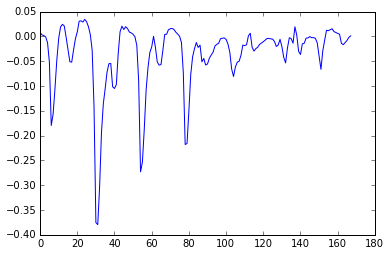

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt

components = pca.components_
plt.plot(components[0])

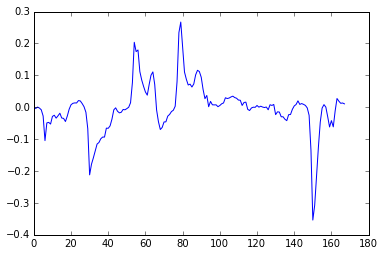

In [181]:
plt.plot(components[1])

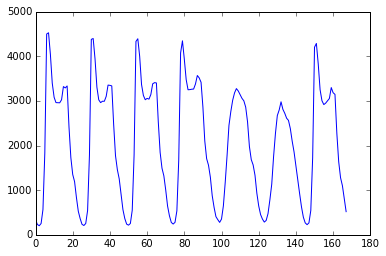

In [182]:
plt.plot(np.mean(vectors, axis=0))

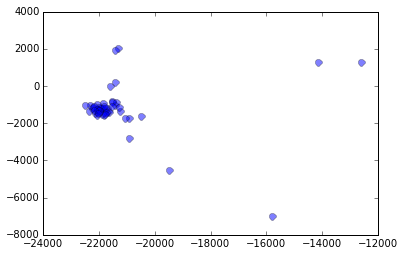

In [195]:
for v in vectors:
    plt.plot(v.dot(components[0]), v.dot(components[1]),
     'o', markersize=7, color='blue', alpha=0.5, label='class1')

In [189]:
vectors[0].dot(components[1])

-1203.9891379783321